In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
from IPython.display import clear_output

In [31]:
PERIOD = "max"
TICKER_SYMBOL = "GOOG"
DATASET_FILE = f"{TICKER_SYMBOL}.csv"

In [30]:
# download data - yfinance

t = TICKER_SYMBOL

df = yf.download([t], period=PERIOD, progress=False, rounding=True)
if not df.empty:
    df.to_csv(DATASET_FILE)

$MSFT: possibly delisted; no price data found  (period=1mo)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,


In [32]:
# add SMA200 to data

t = TICKER_SYMBOL
df = pd.read_csv(DATASET_FILE)

# rename columns, delete unnecessary rows, cut Date time
df.rename(columns={"Price": "Date"}, inplace=True)
df.drop(index=[0, 1], inplace=True)

SMA_PERIOD = 200
# Compute SMA
df["sma"] = df["Adj Close"].rolling(window=SMA_PERIOD).mean().round(2)

# Select and rename the required columns
df = (
    df[["Adj Close", "Volume", "sma"]]
    .iloc[199:]
    .rename(columns={"Adj Close": "price", "Volume": "volume"})
)

# Save to a CSV file
df.to_csv(DATASET_FILE, index=False)

print(f"Ticker: {t}")
print(df.head())
print(df.dtypes)

Ticker: GOOG
     price      volume   sma
201   7.28   976566743  4.51
202   6.95  1031889331  4.53
203   7.11   660109011  4.55
204   7.02   509767599  4.57
205   7.03   514047581  4.59
price     float64
volume      int64
sma       float64
dtype: object


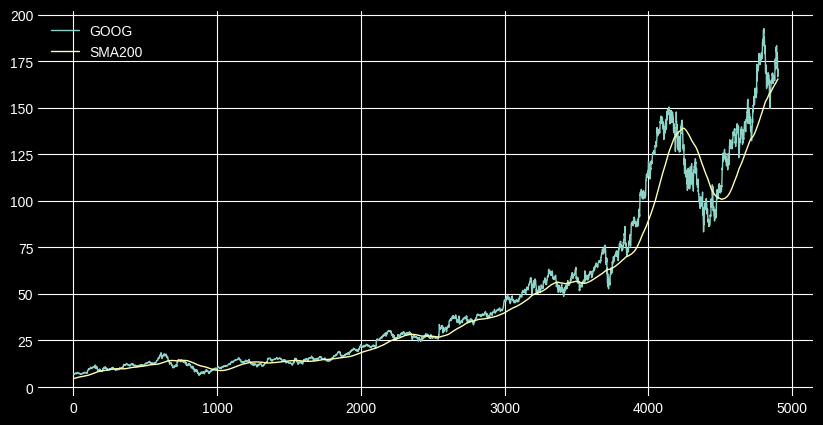

In [ ]:
plt.style.use("default")
plt.style.use("seaborn-v0_8-darkgrid")
plt.style.use("dark_background")

# Plot the 'Close' price against the 'Date'
plt.figure(figsize=(10, 5))

df = pd.read_csv(f"{t}.csv")
plt.plot(df.index, df["price"], label="price", linewidth=1)
plt.plot(df.index, df["sma"], label="sma", linewidth=1)

plt.grid(True)
plt.legend([t, f"SMA{SMA_PERIOD}"])

plt.show()